In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [25]:
# Define directories
data_dir = "cancerSeno_bw/train"
output_dir = "featuresTest"
classes = ["sano", "cancer"]

# Create output directories for unified data
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls, "UnifiedFeatures"), exist_ok=True)

In [26]:
def read_csv_to_df(class_name, feature):
    """Read CSV file into a dataframe."""
    file_path = os.path.join(output_dir, class_name, feature, f"combined_{feature}.csv")
    return pd.read_csv(file_path)

In [27]:
# Initialize dictionaries to store dataframes
data_frames = {cls: {} for cls in classes}

In [28]:
# Read dataframes
for cls in classes:
    data_frames[cls]['pixel_density'] = read_csv_to_df(cls, "pixelDensity")
    data_frames[cls]['brightness'] = read_csv_to_df(cls, "brightness")
    data_frames[cls]['std_deviation'] = read_csv_to_df(cls, "stdDeviation")

# Combine dataframes for each class
for cls in classes:
    combined_df = pd.concat([
        data_frames[cls]['pixel_density'],
        data_frames[cls]['brightness'],
        data_frames[cls]['std_deviation']
    ], axis=1)
    combined_df.columns = ['pixel_density', 'brightness', 'std_deviation']
    combined_df.to_csv(os.path.join(output_dir, cls, "UnifiedFeatures", "combined_features.csv"), index=False)


In [29]:
# Read combined dataframes
combined_sano_df = pd.read_csv(os.path.join(output_dir, "sano", "UnifiedFeatures", "combined_features.csv"))
combined_cancer_df = pd.read_csv(os.path.join(output_dir, "cancer", "UnifiedFeatures", "combined_features.csv"))

# Add diagnosis column
combined_sano_df['diagnosis'] = 0
combined_cancer_df['diagnosis'] = 1

# Concatenate both dataframes
final_df = pd.concat([combined_sano_df, combined_cancer_df], ignore_index=True)

# Drop rows with NaN values
final_df.dropna(inplace=True)

# Save the final dataframe
final_df.to_csv(os.path.join(output_dir, "combined_features.csv"), index=False)

print("done")

done


In [30]:
# Load the final combined dataframe
final_df = pd.read_csv(os.path.join(output_dir, "combined_features.csv"))

In [31]:
final_df.head(5)

,pixel_density,brightness,std_deviation,diagnosis
0,0.171509,224.2464,60.422798,0
1,0.159555,215.8540,59.209350,0
2,1.569373,130.9068,57.393098,0
3,0.780627,155.0704,63.576466,0
4,0.270971,177.7340,57.196350,0


In [32]:
final_df.size

439400

In [33]:
final_df.shape

(109850, 4)

In [34]:
final_df.tail(5)

,pixel_density,brightness,std_deviation,diagnosis
109845,0.431025,137.2384,37.947785,1
109846,0.459428,131.4040,25.983502,1
109847,0.019992,210.0556,38.063165,1
109848,0.041233,171.9496,40.148622,1
109849,0.041233,182.3728,44.743395,1


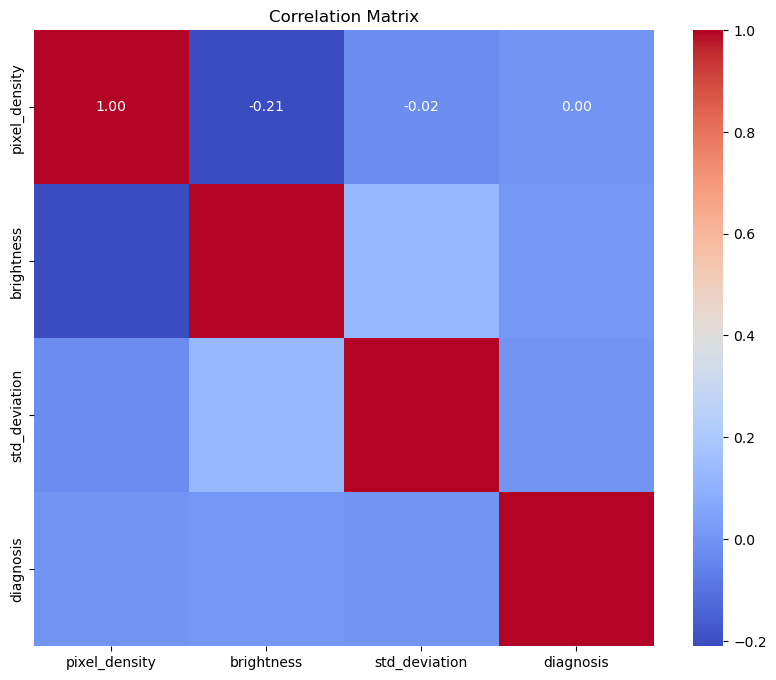

In [35]:
# Load the final combined dataframe
final_df = pd.read_csv(os.path.join(output_dir, "combined_features.csv"))

# Calculate the correlation matrix
correlation_matrix = final_df.corr()

# Save the correlation matrix
correlation_matrix.to_csv(os.path.join(output_dir, "correlation_matrix.csv"))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [36]:
# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[4791 6293]
 [4612 6274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47     11084
           1       0.50      0.58      0.54     10886

    accuracy                           0.50     21970
   macro avg       0.50      0.50      0.50     21970
weighted avg       0.50      0.50      0.50     21970


Accuracy Score:
0.503641329085116


In [37]:
# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define the hyperparameters grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['saga']
}

# Create GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, ver

Best parameters found:  {'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Confusion Matrix:
[[4186 6898]
 [3942 6944]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.38      0.44     11084
           1       0.50      0.64      0.56     10886

    accuracy                           0.51     21970
   macro avg       0.51      0.51      0.50     21970
weighted avg       0.51      0.51      0.50     21970


Accuracy Score:
0.5065999089667729


### Implementación de random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [34]:
# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[6456 4628]
 [3345 7541]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62     11084
           1       0.62      0.69      0.65     10886

    accuracy                           0.64     21970
   macro avg       0.64      0.64      0.64     21970
weighted avg       0.64      0.64      0.64     21970


Accuracy Score:
0.63709604005462


### Random forest with hyperparams

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [39]:
# Load the final dataframe
final_df = pd.read_csv("featuresTest/combined_features.csv")

# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Random Forest parameter grid
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define pipeline
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('model', rf_model)])

# Perform GridSearchCV
print("Running GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Store the best estimator
best_rf = grid_search_rf.best_estimator_

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

# Evaluate the model
y_pred_rf = best_rf.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Running GridSearchCV for Random Forest...
Best parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best score for Random Forest: 0.7466772872098316

Confusion Matrix:
[[ 6262  4822]
 [  754 10132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69     11084
           1       0.68      0.93      0.78     10886

    accuracy                           0.75     21970
   macro avg       0.79      0.75      0.74     21970
weighted avg       0.79      0.75      0.74     21970


Accuracy Score:
0.7461993627674101


### Gradient boost normi

In [41]:
# Load the final dataframe
final_df = pd.read_csv("featuresTest/combined_features.csv")

# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define pipeline
pipeline_gbm = Pipeline([('scaler', StandardScaler()), ('model', gbm_model)])

# Train the model
pipeline_gbm.fit(X_train, y_train)

# Evaluate the model
y_pred_gbm = pipeline_gbm.predict(X_test)
print("\nGradient Boosting Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_gbm))


Gradient Boosting Model Evaluation

Confusion Matrix:
[[5815 5269]
 [ 906 9980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.52      0.65     11084
           1       0.65      0.92      0.76     10886

    accuracy                           0.72     21970
   macro avg       0.76      0.72      0.71     21970
weighted avg       0.76      0.72      0.71     21970


Accuracy Score:
0.7189349112426036


## Gradient boost hyperparams

In [41]:
# Define Gradient Boosting parameter grid
param_grid_gbm = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1, 1],
    'model__max_depth': [3, 5, 7],
}

# Define Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define pipeline
pipeline_gbm = Pipeline([('scaler', StandardScaler()), ('model', gbm_model)])

# Perform GridSearchCV
print("Running GridSearchCV for Gradient Boosting...")
grid_search_gbm = GridSearchCV(pipeline_gbm, param_grid_gbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gbm.fit(X_train, y_train)

# Store the best estimator
best_gbm = grid_search_gbm.best_estimator_

print(f"Best parameters for Gradient Boosting: {grid_search_gbm.best_params_}")
print(f"Best score for Gradient Boosting: {grid_search_gbm.best_score_}")

# Evaluate the model
y_pred_gbm = best_gbm.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_gbm))

import pickle

with open(os.path.join("demo","GBoost_tunned.pkl"), "wb") as file:
    pickle.dump(best_gbm, file)

Running GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Best score for Gradient Boosting: 0.7532885753299954

Confusion Matrix:
[[ 6253  4831]
 [  663 10223]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69     11084
           1       0.68      0.94      0.79     10886

    accuracy                           0.75     21970
   macro avg       0.79      0.75      0.74     21970
weighted avg       0.79      0.75      0.74     21970


Accuracy Score:
0.7499317250796541


### Support vector machine normie

In [44]:
# Load the final dataframe
final_df = pd.read_csv("featuresTest/combined_features.csv")

# Define features and target
X = final_df[['pixel_density', 'brightness', 'std_deviation']]
y = final_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SVM model
svm_model = SVC(probability=True, random_state=42)

# Define pipeline
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('model', svm_model)])

# Train the model
pipeline_svm.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = pipeline_svm.predict(X_test)
print("\nSupport Vector Machines Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_svm))


Support Vector Machines Model Evaluation

Confusion Matrix:
[[ 4253  6831]
 [  218 10668]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.38      0.55     11084
           1       0.61      0.98      0.75     10886

    accuracy                           0.68     21970
   macro avg       0.78      0.68      0.65     21970
weighted avg       0.78      0.68      0.65     21970


Accuracy Score:
0.6791533909877105


## Svm hyperparams

In [45]:
# Define SVM parameter grid
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__gamma': [0.001, 0.01, 0.1],
    'model__kernel': ['linear', 'rbf'],
}

# Define SVM model
svm_model = SVC(probability=True, random_state=42)

# Define pipeline
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('model', svm_model)])

# Perform GridSearchCV
print("Running GridSearchCV for SVM...")
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Store the best estimator
best_svm = grid_search_svm.best_estimator_

print(f"Best parameters for SVM: {grid_search_svm.best_params_}")
print(f"Best score for SVM: {grid_search_svm.best_score_}")

# Evaluate the model
y_pred_svm = best_svm.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_svm))

Running GridSearchCV for SVM...


KeyboardInterrupt: 

## Obtain test dataframe

In [46]:
# Define directories
output_dir_test = "featuresTestFromTest"

In [47]:
# Load the final combined dataframe
final_df_test = pd.read_csv(os.path.join(output_dir_test, "combined_features_test.csv"))

In [48]:
final_df_test.head(5)

,pixel_density,brightness,std_deviation,diagnosis
0,0.684636,167.8932,72.417016,0
1,0.109632,223.3596,50.889707,0
2,0.260716,171.3472,54.498876,0
3,0.193887,212.4244,57.584104,0
4,0.404494,172.6876,58.721597,0


# Evaluate on test case

## Logistic regression normal

In [49]:
# Prepare the data
X_test = final_df_test[['pixel_density', 'brightness', 'std_deviation']]
y_test = final_df_test['diagnosis']

# Define Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Define pipeline
pipeline_logreg = Pipeline([('scaler', StandardScaler()), ('model', logreg_model)])

# Train the model on the training data
pipeline_logreg.fit(X, y)

# Evaluate the model on the test data
y_pred_logreg = pipeline_logreg.predict(X_test)
print("\nLogistic Regression (Normal) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_logreg))


Logistic Regression (Normal) Model Evaluation

Confusion Matrix:
[[12563 11298]
 [12563 11298]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51     23861
           1       0.50      0.47      0.49     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.50     47722
weighted avg       0.50      0.50      0.50     47722


Accuracy Score:
0.5


## Logistic regression with hyperparams

In [50]:
# Define Logistic Regression model with hyperparameters found previously
logreg_model_hp = LogisticRegression(C=0.01, penalty='l1', solver='saga', random_state=42)

# Define pipeline
pipeline_logreg_hp = Pipeline([('scaler', StandardScaler()), ('model', logreg_model_hp)])

# Train the model on the training data
pipeline_logreg_hp.fit(X, y)

# Evaluate the model on the test data
y_pred_logreg_hp = pipeline_logreg_hp.predict(X_test)
print("\nLogistic Regression (Hyperparameters) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg_hp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg_hp))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_logreg_hp))


Logistic Regression (Hyperparameters) Model Evaluation

Confusion Matrix:
[[12317 11544]
 [12317 11544]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     23861
           1       0.50      0.48      0.49     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.50     47722
weighted avg       0.50      0.50      0.50     47722


Accuracy Score:
0.5


## Random forest normal

In [52]:
# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define pipeline
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('model', rf_model)])

# Train the model on the training data
pipeline_rf.fit(X, y)

# Evaluate the model on the test data
y_pred_rf = pipeline_rf.predict(X_test)
print("\nRandom Forest (Normal) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_rf))


Random Forest (Normal) Model Evaluation

Confusion Matrix:
[[ 1982 21879]
 [ 1982 21879]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.08      0.14     23861
           1       0.50      0.92      0.65     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.39     47722
weighted avg       0.50      0.50      0.39     47722


Accuracy Score:
0.5


## Random forest wih hyperparams

In [53]:
# Define Random Forest model with hyperparameters found previously
rf_model_hp = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

# Define pipeline
pipeline_rf_hp = Pipeline([('scaler', StandardScaler()), ('model', rf_model_hp)])

# Train the model on the training data
pipeline_rf_hp.fit(X, y)

# Evaluate the model on the test data
y_pred_rf_hp = pipeline_rf_hp.predict(X_test)
print("\nRandom Forest (Hyperparameters) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_hp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_hp))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_rf_hp))


Random Forest (Hyperparameters) Model Evaluation

Confusion Matrix:
[[  737 23124]
 [  737 23124]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.06     23861
           1       0.50      0.97      0.66     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.36     47722
weighted avg       0.50      0.50      0.36     47722


Accuracy Score:
0.5


## Gradient boost

In [54]:
# Define Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define pipeline
pipeline_gbm = Pipeline([('scaler', StandardScaler()), ('model', gbm_model)])

# Train the model on the training data
pipeline_gbm.fit(X, y)

# Evaluate the model on the test data
y_pred_gbm = pipeline_gbm.predict(X_test)
print("\nGradient Boosting (Normal) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_gbm))


Gradient Boosting (Normal) Model Evaluation

Confusion Matrix:
[[ 2029 21832]
 [ 2029 21832]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.09      0.15     23861
           1       0.50      0.91      0.65     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.40     47722
weighted avg       0.50      0.50      0.40     47722


Accuracy Score:
0.5


## Gradient boost with hyperparams

In [55]:
# Define Gradient Boosting model with hyperparameters found previously
gbm_model_hp = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=42)

# Define pipeline
pipeline_gbm_hp = Pipeline([('scaler', StandardScaler()), ('model', gbm_model_hp)])

# Train the model on the training data
pipeline_gbm_hp.fit(X, y)

# Evaluate the model on the test data
y_pred_gbm_hp = pipeline_gbm_hp.predict(X_test)
print("\nGradient Boosting (Hyperparameters) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbm_hp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm_hp))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_gbm_hp))


Gradient Boosting (Hyperparameters) Model Evaluation

Confusion Matrix:
[[ 1956 21905]
 [ 1956 21905]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.08      0.14     23861
           1       0.50      0.92      0.65     23861

    accuracy                           0.50     47722
   macro avg       0.50      0.50      0.39     47722
weighted avg       0.50      0.50      0.39     47722


Accuracy Score:
0.5


In [ ]:
# Define SVM model
svm_model = SVC(probability=True, random_state=42)

# Define pipeline
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('model', svm_model)])

# Train the model on the training data
pipeline_svm.fit(X, y)

# Evaluate the model on the test data
y_pred_svm = pipeline_svm.predict(X_test)
print("\nSupport Vector Machine (Normal) Model Evaluation")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_svm))